<a href="https://colab.research.google.com/github/Vargol/StableDiffusionColabs/blob/main/LCM/lcm_sdxl_compel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using a Compel to handle prompts. Demonstrates Compel and using Diffusers to load models without loading the models text encoder and tokenizer.

As usual for these examples the last cell is re-runnable, so new prompts / parameters can be used without recreating the whole environment.

ATM this requires Diffusers 0.22 which isn't out yet so gets Diffusers from source.

In [1]:
%pip install --quiet --upgrade diffusers  transformers accelerate mediapy compel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.2 MB/s eta 0:00:00


In [2]:
import mediapy as media
import random
import sys
import torch
import gc
import time

from diffusers import DiffusionPipeline, AutoencoderKL, LCMScheduler, UniPCMultistepScheduler
from transformers import CLIPTokenizer, CLIPTextModelWithProjection, CLIPTextModel
from compel import Compel, ReturnedEmbeddingsType

refiner = None
pipe = None

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
                                    torch_dtype=torch.float16,
                                    force_upcast=False).to('cuda')


styles = {
"Enhance" : {
"Positive" : "breathtaking {prompt} . award-winning, professional, highly detailed",
"Negative" : "ugly, deformed, noisy, blurry, distorted, grainy",
},
"Anime" : {
"Positive" : "anime artwork {prompt} . anime style, key visual, vibrant, studio anime,  highly detailed",
"Negative" : "photo, deformed, black and white, realism, disfigured, low contrast",
},
"Photographic" : {
"Positive" : "cinematic photo {prompt} . 35mm photograph, film, bokeh, professional, 4k, highly detailed",
"Negative" : "drawing, painting, crayon, sketch, graphite, impressionist, noisy, blurry, soft, deformed, ugly",
},
"Digital art" : {
"Positive" : "concept art {prompt} . digital artwork, illustrative, painterly, matte painting, highly detailed",
"Negative" : "photo, photorealistic, realism, ugly",
},
"Comic book" : {
"Positive" : "comic {prompt} . graphic illustration, comic art, graphic novel art, vibrant, highly detailed",
"Negative" : "photograph, deformed, glitch, noisy, realistic, stock photo",
},
"Fantasy art" : {
"Positive" : "ethereal fantasy concept art of  {prompt} . magnificent, celestial, ethereal, painterly, epic, majestic, magical, fantasy art, cover art, dreamy",
"Negative" : "photographic, realistic, realism, 35mm film, dslr, cropped, frame, text, deformed, glitch, noise, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, sloppy, duplicate, mutated, black and white",
},
"Analog film" : {
"Positive" : "analog film photo {prompt} . faded film, desaturated, 35mm photo, grainy, vignette, vintage, Kodachrome, Lomography, stained, highly detailed, found footage",
"Negative" : "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
},
"Neonpunk" : {
"Positive" : "neonpunk style {prompt} . cyberpunk, vaporwave, neon, vibes, vibrant, stunningly beautiful, crisp, detailed, sleek, ultramodern, magenta highlights, dark purple shadows, high contrast, cinematic, ultra detailed, intricate, professional",
"Negative" : "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
},
"Isometric" : {
"Positive" : "isometric style {prompt} . vibrant, beautiful, crisp, detailed, ultra detailed, intricate",
"Negative" : "deformed, mutated, ugly, disfigured, blur, blurry, noise, noisy, realistic, photographic",
},
"Lowpoly" : {
"Positive" : "low-poly style {prompt} . low-poly game art, polygon mesh, jagged, blocky, wireframe edges, centered composition",
"Negative" : "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Origami" : {
"Positive" : "origami style {prompt} . paper art, pleated paper, folded, origami art, pleats, cut and fold, centered composition",
"Negative" : "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Line art" : {
"Positive" : "line art drawing {prompt} . professional, sleek, modern, minimalist, graphic, line art, vector graphics",
"Negative" : "anime, photorealistic, 35mm film, deformed, glitch, blurry, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, mutated, realism, realistic, impressionism, expressionism, oil, acrylic",
},
"Craft clay" : {
"Positive" : "play-doh style {prompt} . sculpture, clay art, centered composition, Claymation",
"Negative" : "sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Cinematic" : {
"Positive" : "cinematic film still {prompt} . shallow depth of field, vignette, highly detailed, high budget Hollywood movie, bokeh, cinemascope, moody, epic, gorgeous, film grain, grainy",
"Negative" : "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured",
},
"3d-model" : {
"Positive" : "professional 3d model {prompt} . octane render, highly detailed, volumetric, dramatic lighting",
"Negative" : "ugly, deformed, noisy, low poly, blurry, painting",
},
"Pixel art" : {
"Positive" : "pixel-art {prompt} . low-res, blocky, pixel art style, 8-bit graphics",
"Negative" : "sloppy, messy, blurry, noisy, highly detailed, ultra textured, photo, realistic",
},
"Texture" : {
"Positive" : "texture {prompt} top down close-up",
"Negative" : "ugly, deformed, noisy, blurry",
}
}

aspects = {
"12:5" :  { 'x' : 1536  , 'y' :  640 },
"7:4" :   { 'x' : 1344  , 'y' :  768 },
"19:13" : { 'x' : 1216  , 'y' :  832  },
"9:7" :   { 'x' : 1152 , 'y' : 896  },
"1:1" :   { 'x' : 1024 , 'y' : 1024 },
"7:9" :   { 'x' : 896  , 'y' : 1152  },
"13:19" : { 'x' : 832  , 'y' :  1216 },
"4:7" :   { 'x' : 768  , 'y' :  1344 },
"5:12" :  { 'x' : 640  , 'y' :  1536 }
}




The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

(…)xl-vae-fp16-fix/resolve/main/config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Prompt:	Melissa Madden Gray as a skyrim character in a film version of Skyrim
Style:	Cinematic
Seed:	608013001610578566



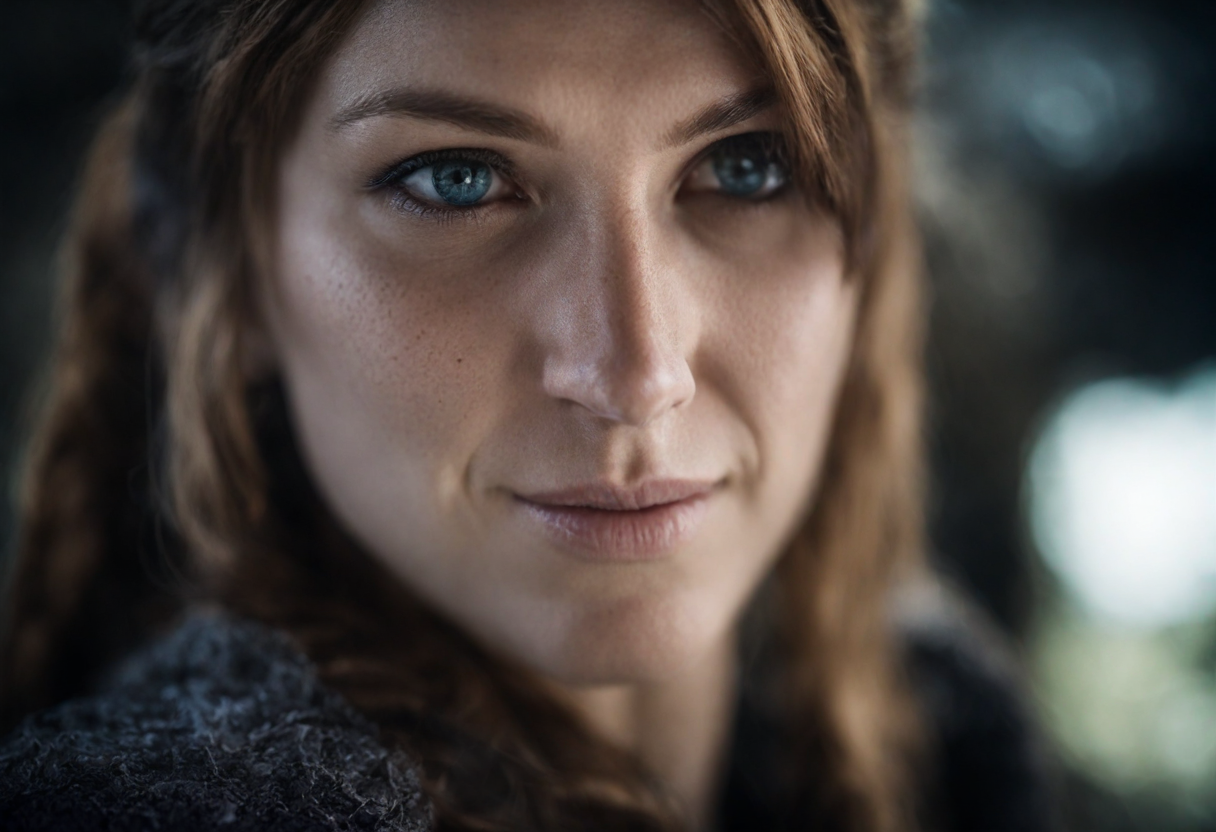

  0%|          | 0/9 [00:00<?, ?it/s]

Prompt:	Melissa Madden Gray as a skyrim character in a film version of Skyrim
Style:	Cinematic
Seed:	538821000538540168



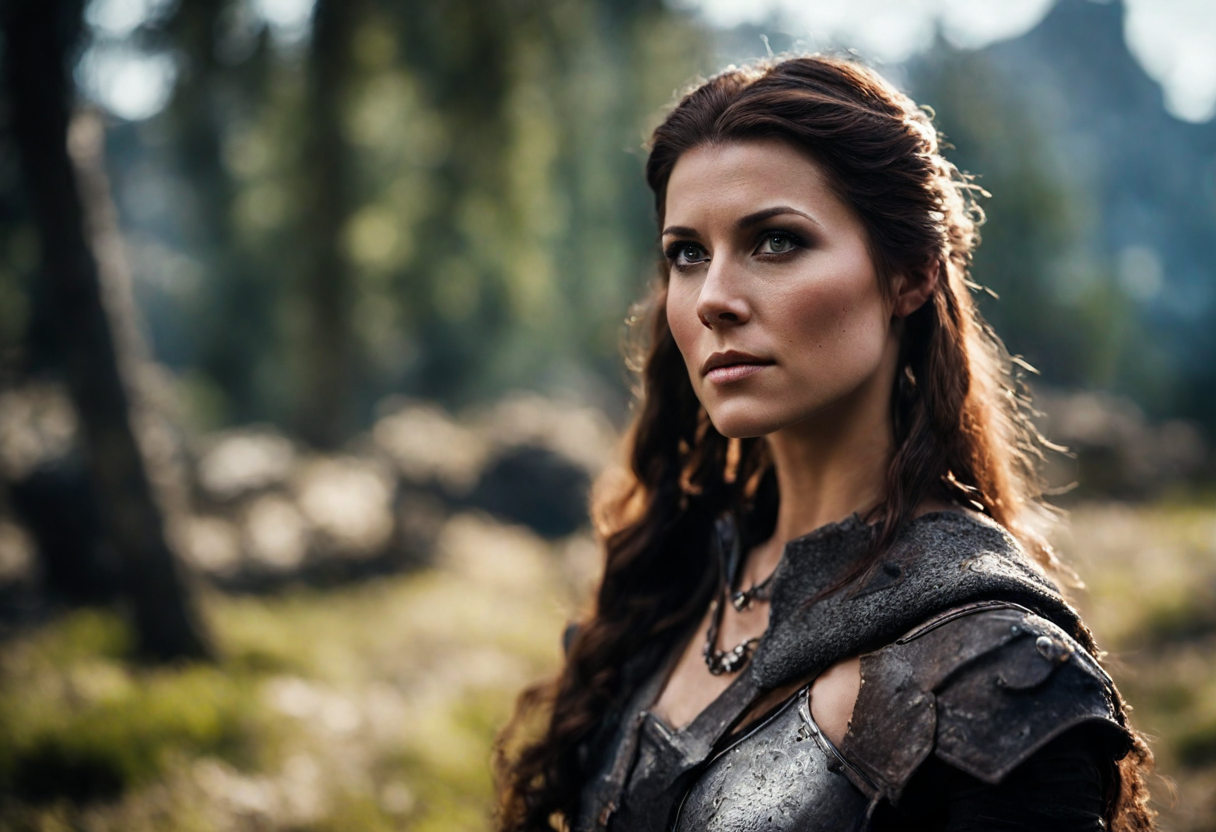

  0%|          | 0/9 [00:00<?, ?it/s]

Prompt:	Melissa Madden Gray as a skyrim character in a film version of Skyrim
Style:	Cinematic
Seed:	4366834607903232423



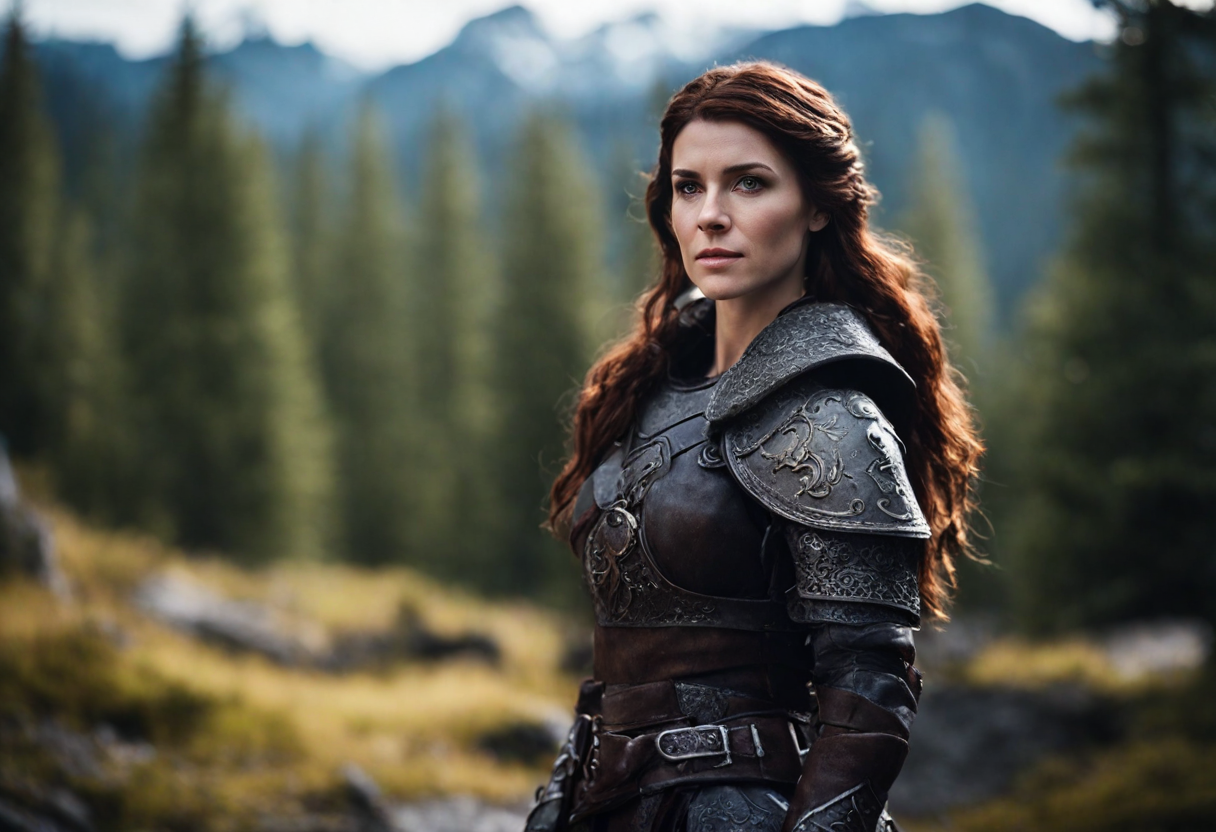

  0%|          | 0/9 [00:00<?, ?it/s]

Prompt:	Melissa Madden Gray as a skyrim character in a film version of Skyrim
Style:	Cinematic
Seed:	6869911726412545519



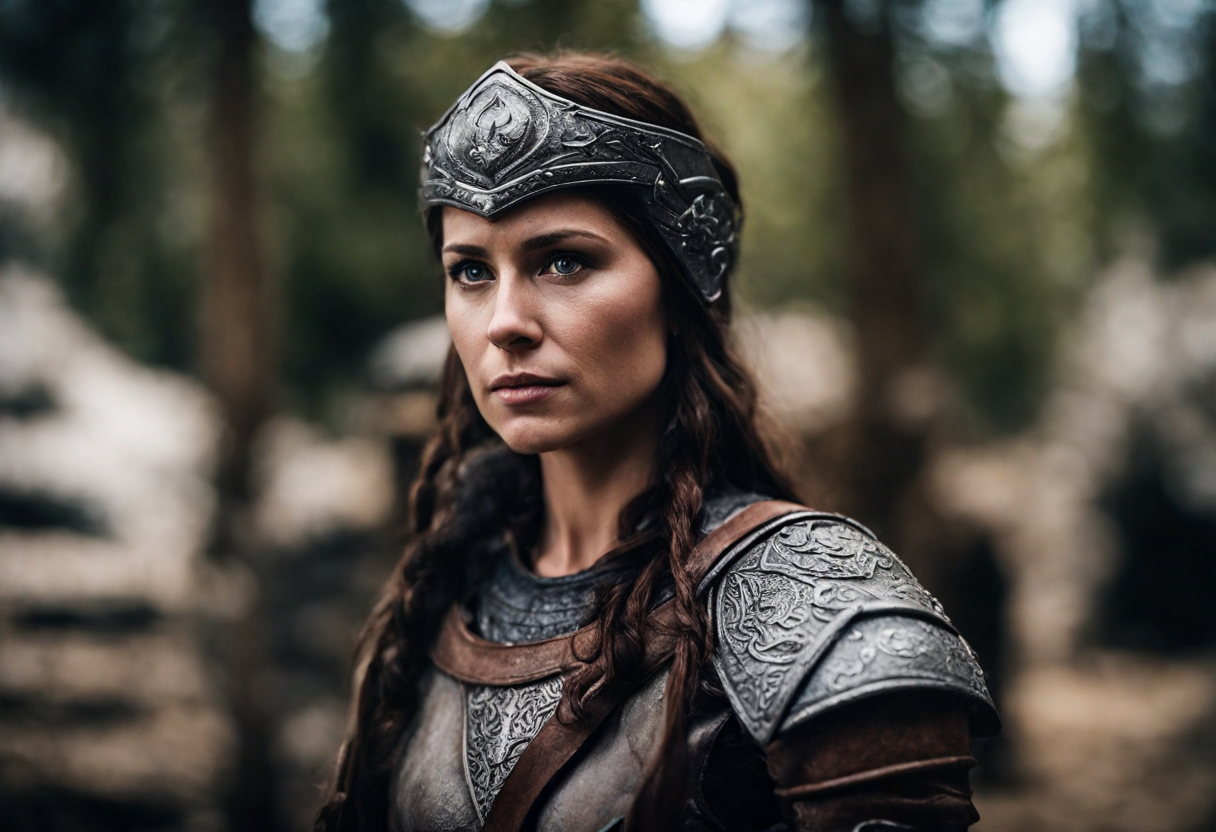

In [7]:
prompt = "Melissa Madden Gray as a skyrim character in a film version of Skyrim"
image_count = 4
use_refiner = True
base_refiner_split=0.8
num_inference_steps=6
style = "Cinematic"
aspect = "19:13"
guidance_scale=1


torch.cuda.empty_cache()
base_output = []
prompt_details = []
generators = []

#lcm_model_id = 'Vargol/lcm-ssd-1b-full-model'
lcm_model_id = 'Vargol/lcm_sdxl_full_model'

orig_prompt = prompt
prompt = styles[style]["Positive"].replace("{prompt}", prompt)
negative_prompt = styles[style]["Negative"]


if pipe is None:

  refiner = None
  gc.collect()
  torch.cuda.empty_cache()

  pipe = DiffusionPipeline.from_pretrained(
      lcm_model_id,
      torch_dtype=torch.float16,
      use_safetensors=True,
      variant="fp16",
      vae=vae,
      ).to('cuda')

  pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
  pipe.enable_vae_tiling()


  compel = Compel(tokenizer=[pipe.tokenizer, pipe.tokenizer_2] ,
                text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
                returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
                requires_pooled=[False, True])

  gc.collect()

conditioning, pooled = compel(prompt)
neg_conditioning, neg_pooled = compel(negative_prompt)

base_output = []
prompt_details = []

for i in range(image_count):

  seed = random.randint(0, sys.maxsize)
  generator =  torch.Generator("cuda").manual_seed(seed);

  kwargs = {
      'prompt_embeds':conditioning,
      'pooled_prompt_embeds':pooled,
      'negative_prompt_embeds':neg_conditioning,
      'negative_pooled_prompt_embeds':neg_pooled,
      'output_type': "latent" if use_refiner else "pil",
      'generator':generator,
      'num_inference_steps':num_inference_steps,
      'width': aspects[aspect]['x'],
      'height': aspects[aspect]['y'],
      'guidance_scale': guidance_scale
  }

  if use_refiner:
    kwargs['denoising_end'] = base_refiner_split

  images = pipe(**kwargs).images

  if use_refiner:
    generators.append(generator)
    base_output.append(images)
    prompt_details.append(f"Prompt:\t{orig_prompt}\nStyle:\t{style}\nSeed:\t{seed}")
  else:
    print(f"Prompt:\t{orig_prompt}\nStyle:\t{style}\nSeed:\t{seed}")
    media.show_images(images)

if use_refiner:

  pipe = None
  gc.collect()
  torch.cuda.empty_cache()

  refiner = DiffusionPipeline.from_pretrained(
      "stabilityai/stable-diffusion-xl-refiner-1.0",
      vae=vae,
      torch_dtype=torch.float16,
      use_safetensors=True,
      variant="fp16",
  ).to('cuda')

  refiner.scheduler = UniPCMultistepScheduler.from_config(refiner.scheduler.config)

  refiner.enable_vae_tiling()

  compel = Compel(tokenizer=[refiner.tokenizer_2] ,
                          text_encoder=[refiner.text_encoder_2],
                          returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
                          requires_pooled=[True])


  conditioning, pooled = compel(prompt)
  neg_conditioning, neg_pooled = compel(negative_prompt)
  compel = None

  gc.collect()


  for i in range(image_count):


    if use_refiner:
      images = refiner(
          prompt_embeds=conditioning,
          pooled_prompt_embeds=pooled,
          negative_prompt_embeds=neg_conditioning,
          negative_pooled_prompt_embeds=neg_pooled,
          image = base_output[i],
          num_inference_steps=num_inference_steps * 8,
          denoising_start = base_refiner_split,
          generator = generator,
          ).images

    print(prompt_details[i])
    media.show_images(images)

gc.collect()
torch.cuda.empty_cache()